In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [ ]:
train = pd.read_csv('/content/train_indessa.csv')
test = pd.read_csv('/content/test_indessa.csv')

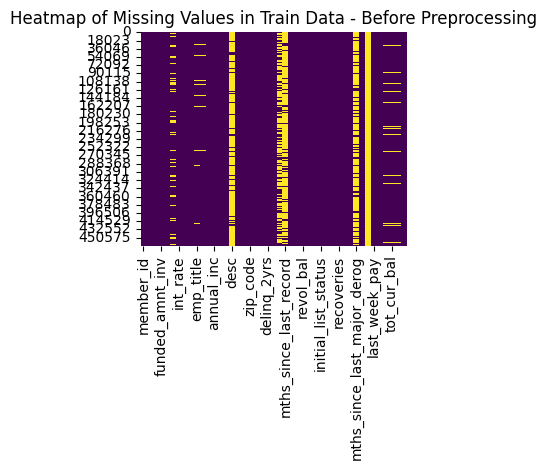

In [ ]:
plt.subplot(1, 2, 1)
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values in Train Data - Before Preprocessing')
plt.tight_layout()
plt.show()

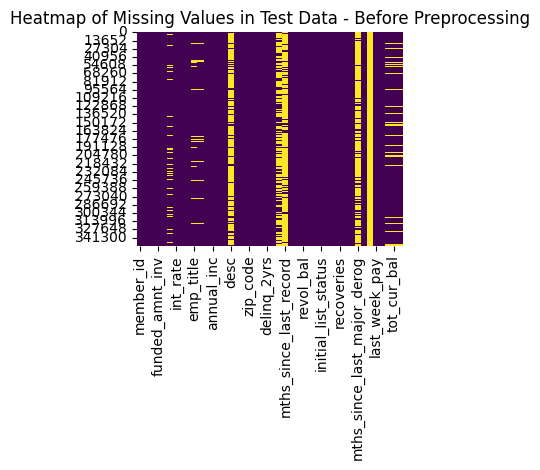

In [ ]:
plt.subplot(1, 2, 2)
sns.heatmap(test.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values in Test Data - Before Preprocessing')
plt.tight_layout()
plt.show()

In [ ]:
print("Unique values in original loan_status:", train['loan_status'].unique())

Unique values in original loan_status: [ 0.  1. nan]


In [ ]:
train = train.dropna(subset=['loan_status'])

In [ ]:
for col in train.select_dtypes(include=[np.number]).columns:
    train[col].fillna(train[col].mean(), inplace=True)
for col in test.select_dtypes(include=[np.number]).columns:
    test[col].fillna(test[col].mean(), inplace=True)

<ipython-input-7-5c35ba1d5a22>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col].fillna(train[col].mean(), inplace=True)


In [ ]:
categorical_cols = train.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    mode_value = train[col].mode()[0]
    train[col].fillna(mode_value, inplace=True)
    test[col].fillna(mode_value, inplace=True)
    le = LabelEncoder()
    combined_data = pd.concat([train[col], test[col]], axis=0)
    le.fit(combined_data)
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

In [ ]:
train['total_payment'] = train['loan_amnt'] + train['funded_amnt'] + train['funded_amnt_inv']
test['total_payment'] = test['loan_amnt'] + test['funded_amnt'] + test['funded_amnt_inv']

In [ ]:
train['income_to_loan_ratio'] = train['annual_inc'] / train['loan_amnt']
test['income_to_loan_ratio'] = test['annual_inc'] / test['loan_amnt']

In [ ]:
train['dti_revol_util'] = train['dti'] * train['revol_util'].fillna(0)
test['dti_revol_util'] = test['dti'] * test['revol_util'].fillna(0)

In [ ]:
train['total_recovery'] = train['recoveries'] + train['total_rec_int']
test['total_recovery'] = test['recoveries'] + test['total_rec_int']

In [ ]:
train['balance_to_credit_ratio'] = train['tot_cur_bal'] / train['total_rev_hi_lim']
test['balance_to_credit_ratio'] = test['tot_cur_bal'] / test['total_rev_hi_lim']

In [ ]:
train['recoveries_to_balance_ratio'] = train['recoveries'] / (train['tot_cur_bal'] + 1)
test['recoveries_to_balance_ratio'] = test['recoveries'] / (test['tot_cur_bal'] + 1)

In [ ]:
train['batch_enrolled_to_total_rec_int'] = train['batch_enrolled'] / (train['total_rec_int'] + 1)
test['batch_enrolled_to_total_rec_int'] = test['batch_enrolled'] / (test['total_rec_int'] + 1)

In [ ]:
train['loan_amnt_total_rec_int_ratio'] = train['loan_amnt'] / (train['total_rec_int'] + 1)
test['loan_amnt_total_rec_int_ratio'] = test['loan_amnt'] / (test['total_rec_int'] + 1)

In [ ]:
train['emp_length_missing'] = train['emp_length'].isnull().astype(int)
test['emp_length_missing'] = test['emp_length'].isnull().astype(int)

In [ ]:
columns_to_drop = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'annual_inc', 'emp_title',
    'home_ownership', 'purpose', 'grade', 'sub_grade', 'desc', 'title', 'zip_code',
    'addr_state', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
    'total_rec_late_fee', 'collection_recovery_fee', 'collections_12_mths_ex_med',
    'mths_since_last_major_derog', 'verification_status_joint', 'acc_now_delinq',
    'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'
]

In [ ]:
train = train.drop(columns=columns_to_drop, errors='ignore')
test = test.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
final_columns = [
    'total_payment', 'income_to_loan_ratio', 'dti_revol_util',
    'total_recovery', 'balance_to_credit_ratio', 'recoveries_to_balance_ratio',
    'batch_enrolled_to_total_rec_int', 'loan_amnt_total_rec_int_ratio',
    'emp_length_missing'
]

In [ ]:
train = train[final_columns + ['loan_status']]
test_features = test[final_columns]

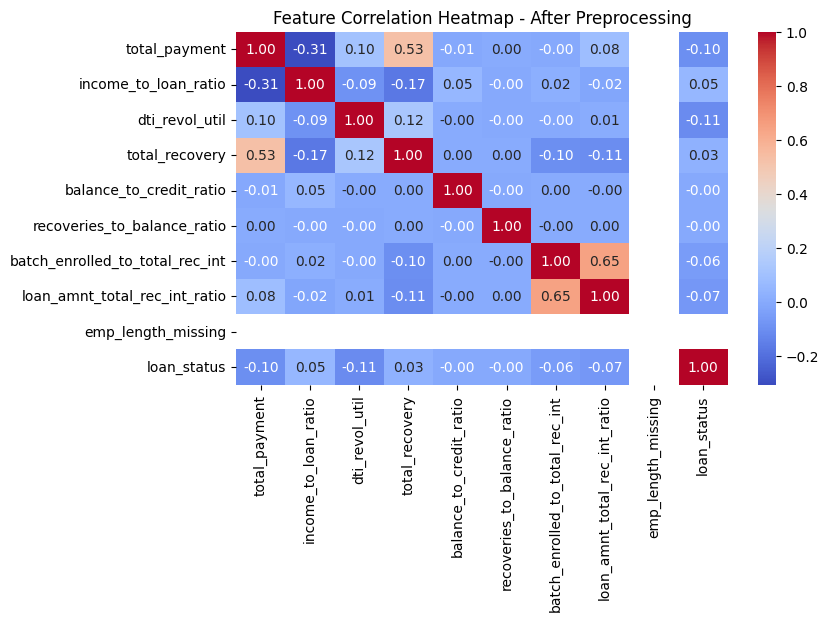

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap - After Preprocessing')
plt.tight_layout()
plt.show()

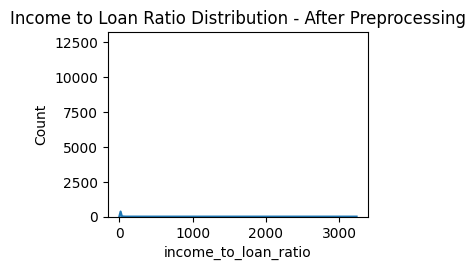

In [ ]:
plt.subplot(2, 2, 2)
sns.histplot(train['income_to_loan_ratio'], kde=True)
plt.title('Income to Loan Ratio Distribution - After Preprocessing')
plt.tight_layout()
plt.show()

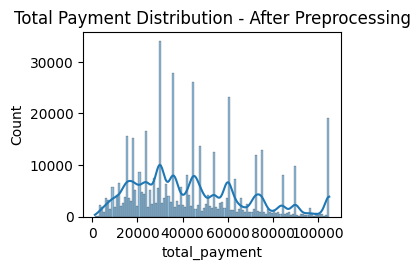

In [ ]:
plt.subplot(2, 2, 3)
sns.histplot(train['total_payment'], kde=True)
plt.title('Total Payment Distribution - After Preprocessing')
plt.tight_layout()
plt.show()

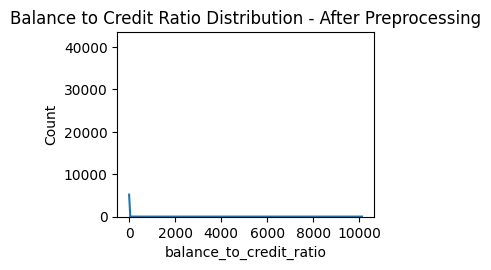

In [ ]:
plt.subplot(2, 2, 4)
sns.histplot(train['balance_to_credit_ratio'], kde=True)
plt.title('Balance to Credit Ratio Distribution - After Preprocessing')
plt.tight_layout()
plt.show()

In [ ]:
print("NaN values in final train data:")
print(train.isnull().sum())

print("\nNaN values in final test data:")
print(test_features.isnull().sum())

NaN values in final train data:
total_payment                      0
income_to_loan_ratio               0
dti_revol_util                     0
total_recovery                     0
balance_to_credit_ratio            6
recoveries_to_balance_ratio        0
batch_enrolled_to_total_rec_int    0
loan_amnt_total_rec_int_ratio      0
emp_length_missing                 0
loan_status                        0
dtype: int64

NaN values in final test data:
total_payment                      0
income_to_loan_ratio               0
dti_revol_util                     0
total_recovery                     0
balance_to_credit_ratio            6
recoveries_to_balance_ratio        0
batch_enrolled_to_total_rec_int    0
loan_amnt_total_rec_int_ratio      0
emp_length_missing                 0
dtype: int64


In [ ]:
train['balance_to_credit_ratio'].fillna(train['balance_to_credit_ratio'].mean(), inplace=True)
test_features['balance_to_credit_ratio'].fillna(test_features['balance_to_credit_ratio'].mean(), inplace=True)

<ipython-input-27-5c0f836cde13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features['balance_to_credit_ratio'].fillna(test_features['balance_to_credit_ratio'].mean(), inplace=True)


In [ ]:
def handle_infinity(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)

handle_infinity(train)
handle_infinity(test_features)

<ipython-input-28-bce6c55e98d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-28-bce6c55e98d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)


In [ ]:
print("Unique values in original loan_status:", train['loan_status'].unique())

Unique values in original loan_status: [0. 1.]


In [ ]:
train['loan_status'] = LabelEncoder().fit_transform(train['loan_status'])

In [ ]:
print("Unique values in original loan_status:", train['loan_status'].unique())

Unique values in original loan_status: [0 1]


In [ ]:
train.to_csv('/content/cleaned_train_indessa.csv', index=False)
test_features.to_csv('/content/cleaned_test_indessa.csv', index=False)

In [ ]:
X = train.drop(columns=['loan_status'])
y = train['loan_status']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("Unique values in y_train:", y_train.unique())
print("Data type of y_train:", y_train.dtype)

Unique values in y_train: [0 1]
Data type of y_train: int64


In [ ]:
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='weighted')
    rec = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    cm = confusion_matrix(y_val, y_pred)
    return acc, prec, rec, f1, cm

In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_acc, lr_prec, lr_rec, lr_f1, lr_cm = evaluate_model(lr_model, X_val, y_val)
print("Logistic Regression - Accuracy:", lr_acc)
print("Logistic Regression - Precision:", lr_prec)
print("Logistic Regression - Recall:", lr_rec)
print("Logistic Regression - F1 Score:", lr_f1)
print("Logistic Regression - Confusion Matrix:\n", lr_cm)

Logistic Regression - Accuracy: 0.7637009688847155
Logistic Regression - Precision: 0.6288881785315054
Logistic Regression - Recall: 0.7637009688847155
Logistic Regression - F1 Score: 0.662438528098956
Logistic Regression - Confusion Matrix:
 [[71550    90]
 [22055    21]]


In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_acc, rf_prec, rf_rec, rf_f1, rf_cm = evaluate_model(rf_model, X_val, y_val)
print("Random Forest - Accuracy:", rf_acc)
print("Random Forest - Precision:", rf_prec)
print("Random Forest - Recall:", rf_rec)
print("Random Forest - F1 Score:", rf_f1)
print("Random Forest - Confusion Matrix:\n", rf_cm)

Random Forest - Accuracy: 0.8268705450510052
Random Forest - Precision: 0.8289577099458572
Random Forest - Recall: 0.8268705450510052
Random Forest - F1 Score: 0.7962950324133081
Random Forest - Confusion Matrix:
 [[70264  1376]
 [14849  7227]]


In [ ]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_acc, gb_prec, gb_rec, gb_f1, gb_cm = evaluate_model(gb_model, X_val, y_val)
print("Gradient Boosting - Accuracy:", gb_acc)
print("Gradient Boosting - Precision:", gb_prec)
print("Gradient Boosting - Recall:", gb_rec)
print("Gradient Boosting - F1 Score:", gb_f1)
print("Gradient Boosting - Confusion Matrix:\n", gb_cm)

Gradient Boosting - Accuracy: 0.820105424900764
Gradient Boosting - Precision: 0.8368939891937216
Gradient Boosting - Recall: 0.820105424900764
Gradient Boosting - F1 Score: 0.7790769850128044
Gradient Boosting - Confusion Matrix:
 [[71092   548]
 [16311  5765]]


In [ ]:
print("Data type of X_train:", type(X_train))
print("Data type of y_train:", type(y_train))
print("Data type of X_val:", type(X_val))
print("Data type of y_val:", type(y_val))

print("Data type of X_train columns:")
print(X_train.dtypes)

print("Data type of y_train:")
print(y_train.dtype)

Data type of X_train: <class 'pandas.core.frame.DataFrame'>
Data type of y_train: <class 'pandas.core.series.Series'>
Data type of X_val: <class 'pandas.core.frame.DataFrame'>
Data type of y_val: <class 'pandas.core.series.Series'>
Data type of X_train columns:
total_payment                      float64
income_to_loan_ratio               float64
dti_revol_util                     float64
total_recovery                     float64
balance_to_credit_ratio            float64
recoveries_to_balance_ratio        float64
batch_enrolled_to_total_rec_int    float64
loan_amnt_total_rec_int_ratio      float64
emp_length_missing                   int64
dtype: object
Data type of y_train:
int64


In [ ]:
xgb_model = xgb.XGBClassifier()
X_train_np = X_train.values
y_train_np = y_train.values
X_val_np = X_val.values
y_val_np = y_val.values

xgb_model.fit(X_train_np, y_train_np)

xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_cm = evaluate_model(xgb_model, X_val_np, y_val_np)
print("XGBoost - Accuracy:", xgb_acc)
print("XGBoost - Precision:", xgb_prec)
print("XGBoost - Recall:", xgb_rec)
print("XGBoost - F1 Score:", xgb_f1)
print("XGBoost - Confusion Matrix:\n", xgb_cm)

XGBoost - Accuracy: 0.8274360834862777
XGBoost - Precision: 0.832234349991555
XGBoost - Recall: 0.8274360834862777
XGBoost - F1 Score: 0.7957504756082084
XGBoost - Confusion Matrix:
 [[70459  1181]
 [14991  7085]]


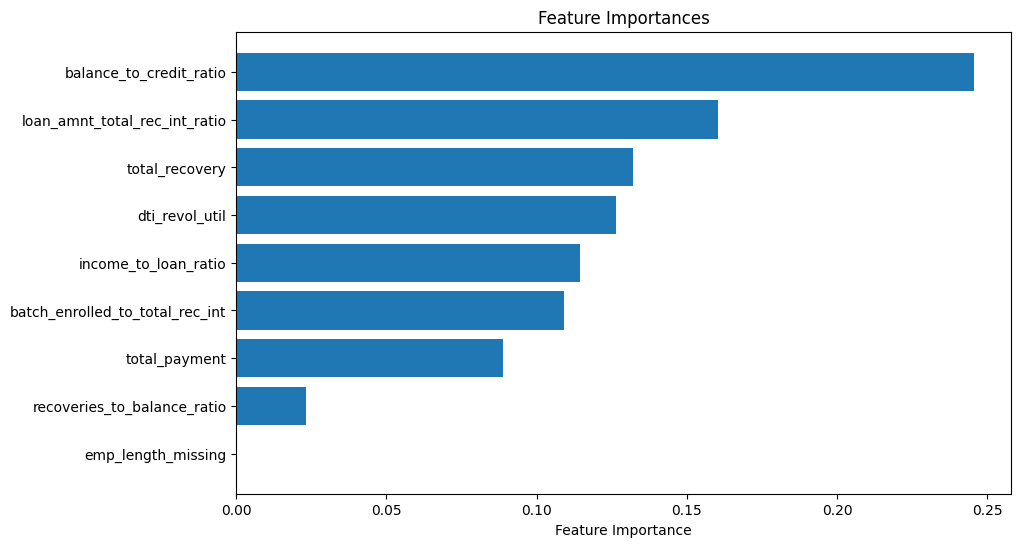

In [ ]:
def plot_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), np.array(features)[indices])
    plt.xlabel('Feature Importance')
    plt.show()

plot_feature_importances(rf_model, X.columns)

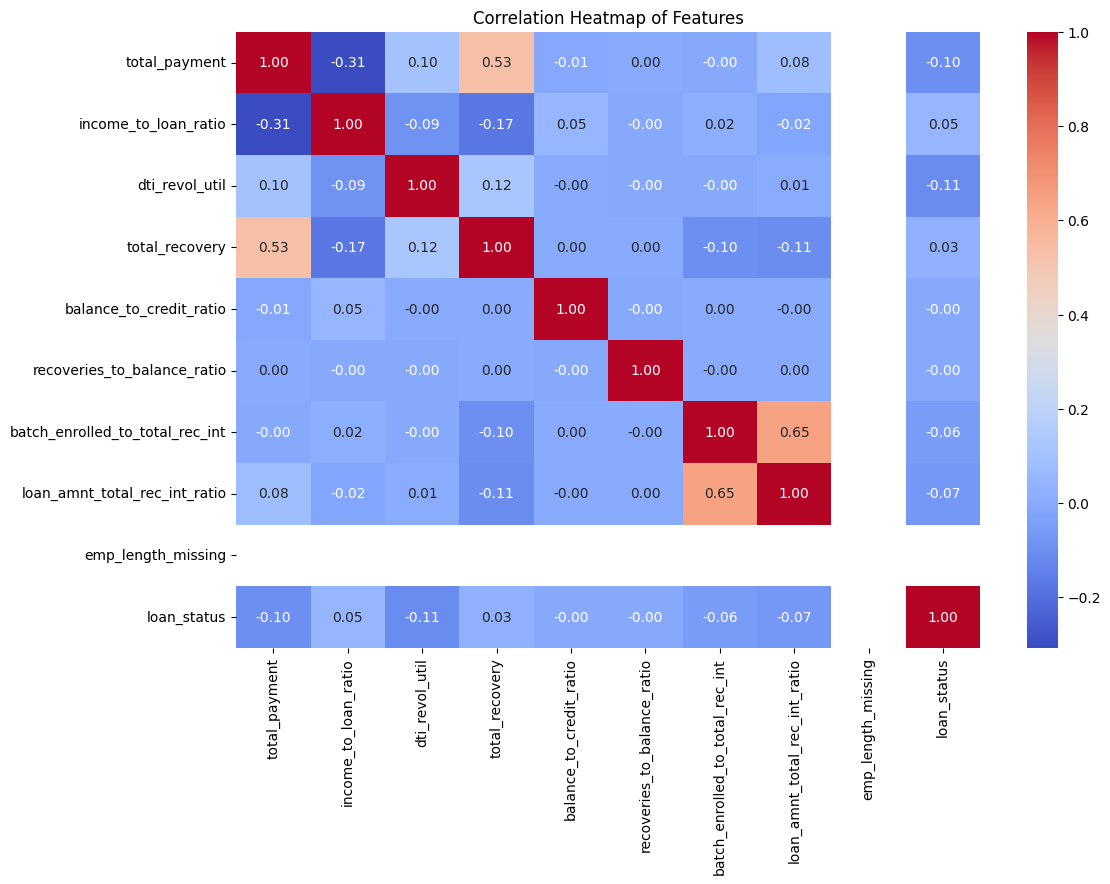

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap of Features')
plt.show()

In [ ]:
member_id = test['member_id']

In [ ]:
lr_predictions = lr_model.predict(test_features)
lr_predictions_df = pd.DataFrame({'member_id': member_id, 'loan_status': lr_predictions})
lr_predictions_df.to_csv('/content/lr_predictions.csv', index=False)

In [ ]:
rf_predictions = rf_model.predict(test_features)
rf_predictions_df = pd.DataFrame({'member_id': member_id, 'loan_status': rf_predictions})
rf_predictions_df.to_csv('/content/rf_predictions.csv', index=False)

In [ ]:
gb_predictions = gb_model.predict(test_features)
gb_predictions_df = pd.DataFrame({'member_id': member_id, 'loan_status': gb_predictions})
gb_predictions_df.to_csv('/content/gb_predictions.csv', index=False)

In [ ]:
xgb_predictions = xgb_model.predict(test_features.values)
xgb_predictions_df = pd.DataFrame({'member_id': member_id, 'loan_status': xgb_predictions})
xgb_predictions_df.to_csv('/content/xgb_predictions.csv', index=False)

In [ ]:
import joblib

In [ ]:
joblib_file = "xgboost_model.pkl"
joblib.dump(xgb_model, joblib_file)
print(f"Model saved as {joblib_file}")

Model saved as xgboost_model.pkl
